<a href="https://colab.research.google.com/github/Mateojs11/DS4all/blob/main/case_study_10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Which salient variables influence the price of homes?

In [ ]:
# Load packages
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Goals (4 min)

As we have discussed in previous cases, one of fundamental challenges in data science and machine learning is to develop models that behave well with out-of-sample data. Very often, we have at our disposal models which admit a large number of *parameters*, or *degree of complexity* (e.g. number of features of a regressor, the depth of a decision tree, number of clusters in a clustering algorithm, etc.). The more complex our model is, the more dependent it will be on our training data and the less applicable it will be more generally (i.e. *overfitting*). In contrast, if our model is too simple, there is a high chance it will be less accurate and thus again not applicable more generally (i.e. *underfitting*). How do we choose the right level of complexity for our models?

In this case you will learn the concept of **regularization**. You will learn how regularization can help in preventing overfitting/underfitting in your models. We will focus on regularization methods for linear regression; however, these techniques apply to other models as well.

## Introduction (5 min)

**Business Context.** The modern real estate business is increasingly dominated by large quantities of data. Real estate investment requires sound judgment and accurate price prediction to determine if a property is a suitable investment. Given the illiquid nature of real estate investments, there are a number of complications that can arise when pricing property. Therefore it is of great interest for real estate investors to understand which variables affect home prices so they can plan their investment portfolios with greater clarity and confidence. You recently joined the housing growth division at a multinational corporation, and have been tasked with identifying factors that affect housing prices. 

**Business Problem.** Your task is to answer the following question: **"Which variables are most important for predicting home prices?"**

**Analytical Context.** The case will proceed as follows: you will 1) explore the data to get some insight into the useful features; 2) apply L1 regularization to reduce the number of variables in your initial linear model; 3) apply L2 regularization to deal with multicollinearity and reduce the variable count further; and finally 4) use both L1 and L2 regularization together via Elastic net regression to get the benefits of both in one model.

## Getting started with the Saratoga home price data (5 min)

Let's load the data into a `pandas` DataFrame. There are fifteen features that may be used to predict the ```price``` of a home:

Quantity of Interest:
1. price (millions of US dollars)

Numerical non-categorical features:
1. **lotSize**: size of the lot in acres
2. **age**: age of the house in years
3. **landValue**: value of the land in US dollars
4. **livingArea**: living area in square feet
5. **pctCollege**: percent of the neighborhood that graduated college

Numeric categorical features:
1. **bedrooms**: number of bedrooms
2. **fireplaces**: number of fireplaces
3. **bathrooms**: number of bathrooms
4. **rooms**: number of rooms

Non-numeric categorical features:
1. **heating**: what type of heating the house uses
2. **fuel**: what type of fuel the house uses
3. **sewer**: what type of sewer system the house has
4. **waterfront**: whether or not the house has a waterfront
5. **newConstruction**: whether or not the house has new construction
6. **centralAir**: whether or not the house has a central air system

In [ ]:
# Load and preview data
df = pd.read_csv('/content/saratoga-houses_clean.csv')
df.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,0.132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,0.181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,0.109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,0.155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,0.086060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


## Exploring feature relationships through data visualization (20 min)

Let's start by visualizing the relationship between the variables and house prices via 2D scatterplots, beginning with the numeric non-categorical features:

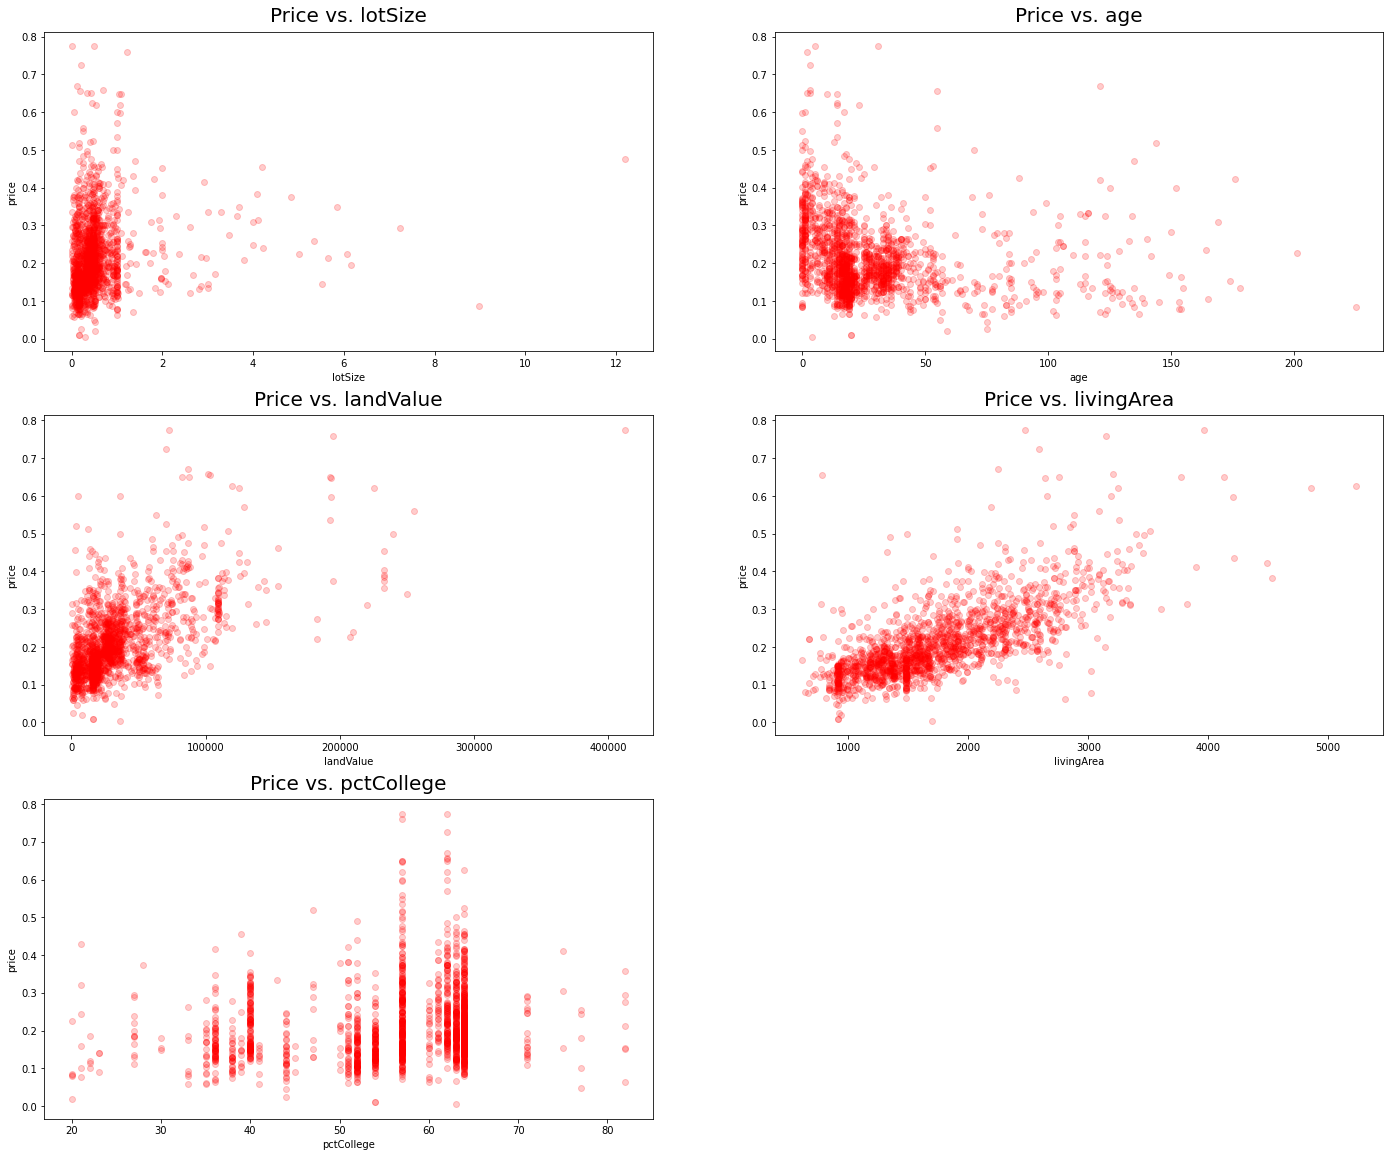

In [ ]:
# Numeric non-catgorical features
plt.figure(figsize=(24,20))
varstolook = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    colvalues = df[feature]
    plt.scatter(colvalues.values, df.price.values, alpha=0.20, edgecolor=None, color='red')
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title("Price vs. " + feature, fontsize=20, verticalalignment='bottom');

A few observations are evident. First, ```livingArea```, ```landValue```, and ```lotSize``` are positively correlated with house prices. Next, the age of a home is inversely correlated with price up to about 50 years, after which the price-age relationship becomes flat. Interestingly, the ```pctCollege``` variable exhibits clusters around certain percentages; however, there doesn't seem to be any strong relationship between price and ```pctCollege```.

Let's look at the numerical categorical features to see if we can notice any significant patterns:

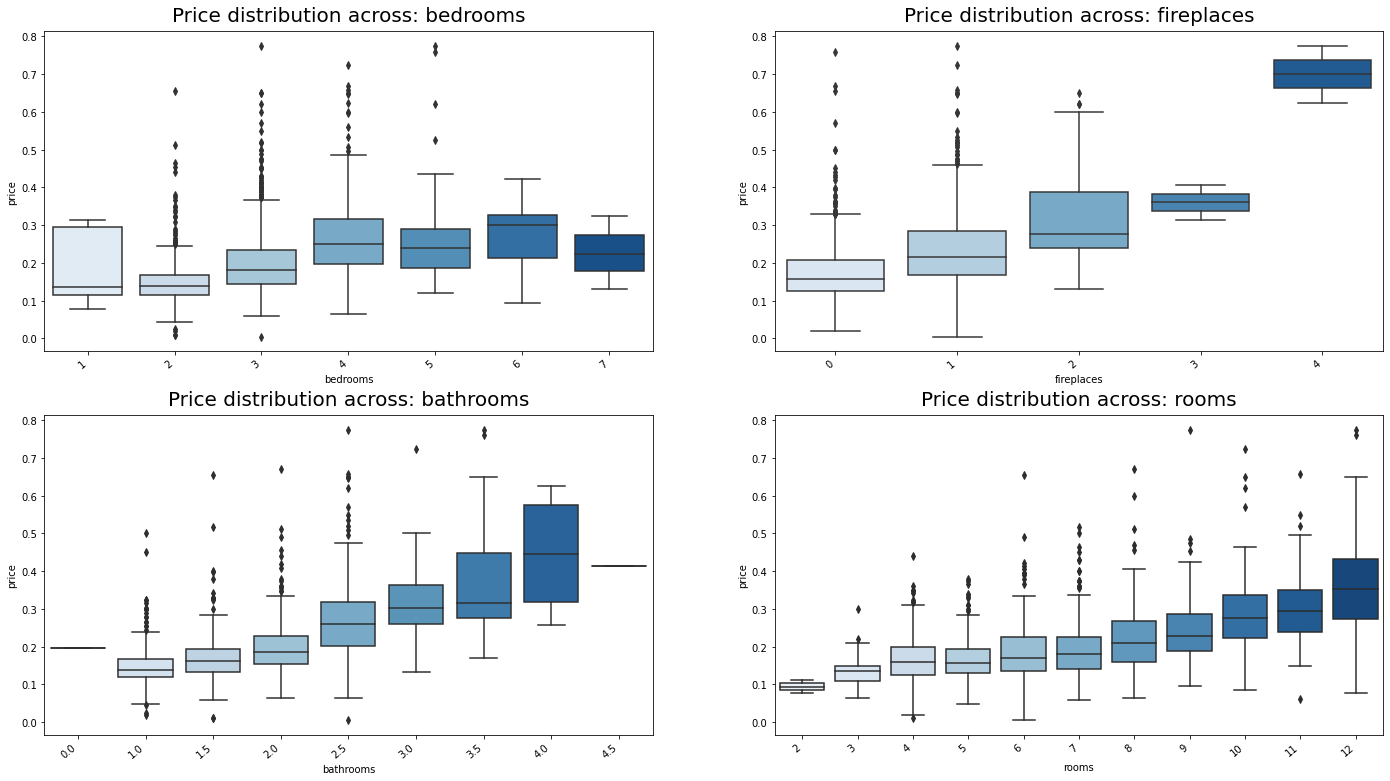

In [ ]:
# Numeric categorical features
plt.figure(figsize=(24,20))
varstolook = ['bedrooms', 'fireplaces', 'bathrooms', 'rooms']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Blues")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

We immediately notice the strong relationship that ```rooms```, ```bathrooms```, and ```fireplaces``` have with home prices. This is expected as larger homes naturally have more rooms and demand a higher asking price. Regarding the ```bedrooms``` feature, the trend of increasing prices is also present as the number of bedrooms increases, but it is weaker at a low (1) and a high (7) number of bedrooms.

### Exercise 1: (10 min)

Create boxplots to visualize each non-numeric categorical feature against prices for each category value within those categorical features. You should have six plots with boxplots for each category value, one for each non-numeric categorical feature:

1. `heating`
2. `fuel`
3. `sewer`
4. `waterfront`
5. `newConstruction`
6. `centralAir`

**Answer.** One possible solution is shown below:

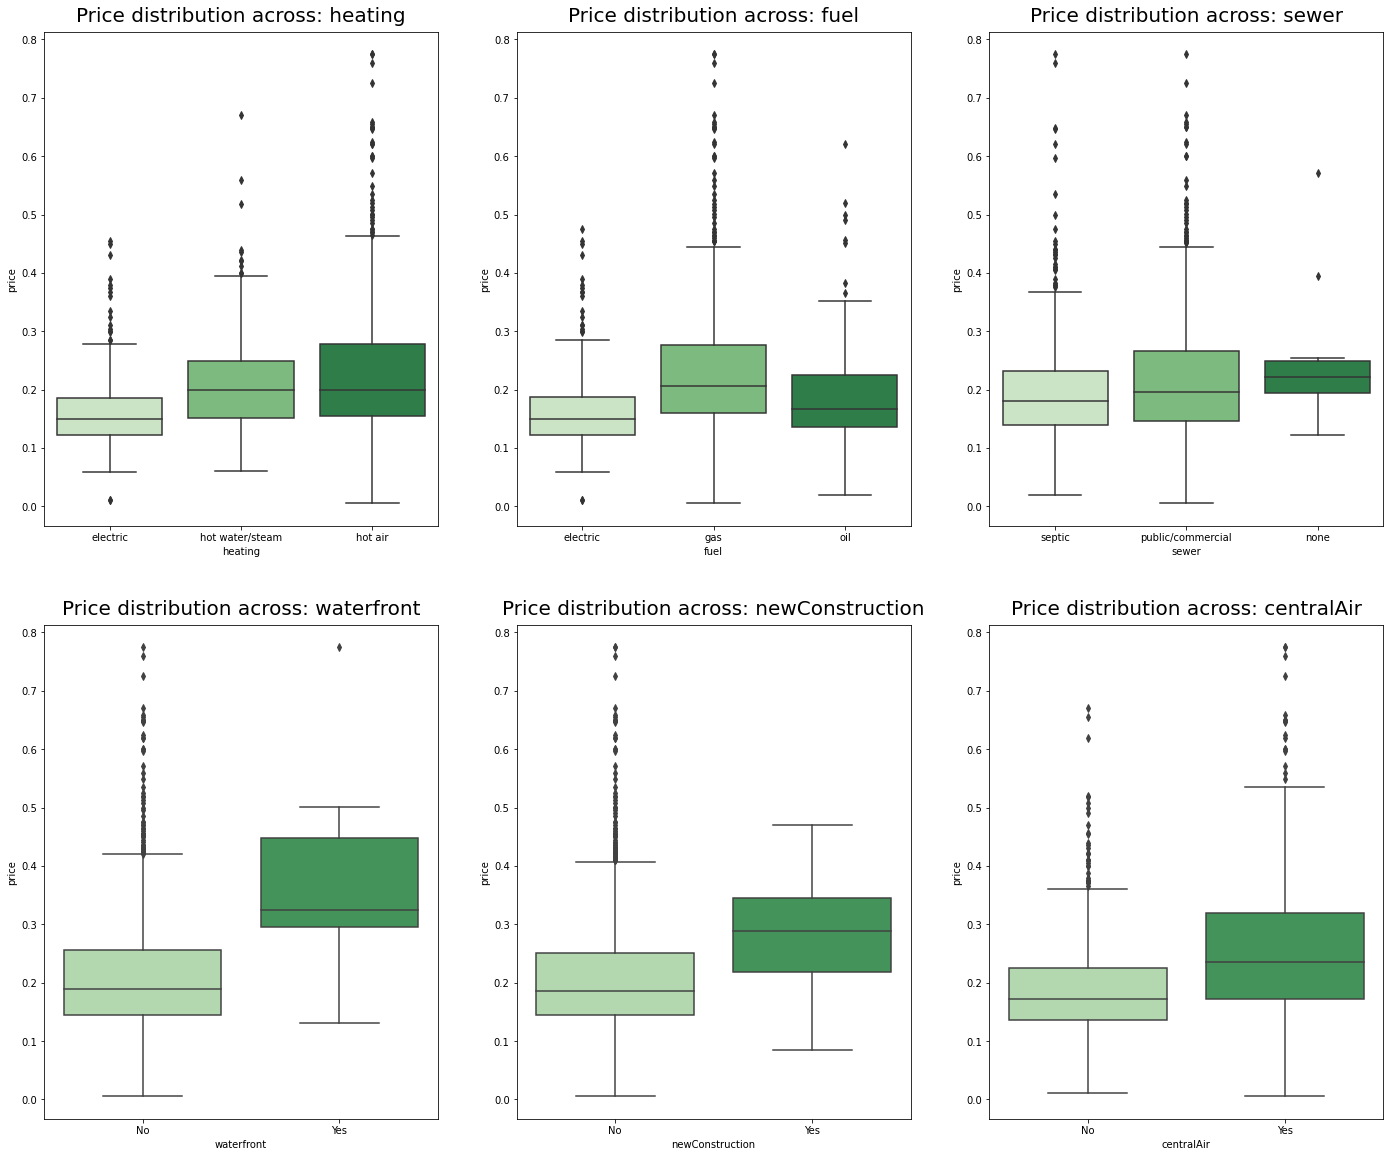

In [ ]:
# One possible solution
plt.figure(figsize=(24,20))
varstolook = ['heating', 'fuel','sewer', 'waterfront', 'newConstruction', 'centralAir']
for i,feature in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Greens")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=0, ha="center");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

As expected, a waterfront property, newly constructed units, and homes with central air are all accompanied by higher prices. While weaker, there are some differences across heating, fuel, and sewer variables. Hot air heating, gas fuel, and public/commerical sewer systems charge higher house prices than their adjacent categorical values.

### Exercise 2: (4 min)

There were some relationships that may not have been expected, such as the weak relationship between ```pctCollege``` and home prices. Which of the following may be a possible external driver of this weak relationship?

A. Neighbourhoods are situated near excellent amenities, driving all the home prices up

B. Neighbourhood residents are diverse and hold an even distribution of income levels and education

C. People tend to live in neighbourhoods where their friends live

D. The data collection procedure for ```pctCollege``` was taken over the phone

**Answer.** (B). The explanation is given below.

Answer (A) doesn't immediately lead to any conclusion on why there is a weak relationship between home price and percent college. All (A) implies is that all homes have a higher price due to proximity to attractive amenties and nothing about the distribution of those home prices.

Answer (B) is the ideal choice as having diverse residents in each neighbourhood, in terms of income and education level, will lead to weak relationships in predicting home prices from these quantities. While it may be true that higher income residents own more expensive homes, the percent college variable is relative to a neighbourhood, so an averaging effect will weaken the relationship to price for any given home if the neighbourhood is educationally well-represented.

Answer (C) would likely lead to a stronger relationship between percent college and home prices if it were true in this data set. Friends often have similar interests and may have similar education backgrounds, which could influence neighbourhood percent college averages to become more correlated to home prices.

Regarding answer (D), it tells us nothing about the relationship between percent college and price so it is incorrect. However, it's important to understand the data in this case was acquired by some method. Hence, there may be data errors or bias in the given data. While we will not explore data acquisition methods in this case, if the data was indeed collected over the phone, it would be important to know the response rate by location to determine if each neighbourhood was equally represented.

## Our first model (10 min)

### Preparing the data (5 min)

Before we begin modeling the data, let's make some simple tranformations. First let's transform the categorical variables with just two categories into binary values where 1 indicates that the effect is present, and zero indicates the effect is not present. This will allow for easy standardization of each feature present in the data:

In [ ]:
# Encoding for non-numeric categorical variables
df2 = pd.get_dummies(df, columns=['heating', 'fuel'], drop_first=False)
df2 = pd.get_dummies(df2, columns=['sewer'], drop_first=True)
df2.replace({'waterfront': {"No":0, "Yes":1},
             'newConstruction': {"No":0, "Yes":1},
             'centralAir': {"No":0, "Yes":1}}, inplace=True)

Next, let's split the data into a training set, a test set, and a validation set. We have extracted a validation set as later we will need to perform some parameter tuning on our model (see also Exercise 4 for a cross-validation variant). We choose to retain 20 percent of the data for the test set and have a 16 percent validation set (which is 20 percent of the training set size):

In [ ]:
# Ready data for multiple regression
X = df2.drop(['price'], axis=1)
y = df2[['price']].values.ravel()

# Split Train, Validation and Test Data
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)

Finally, let's normalize the data. As we have seen with clustering algorithms, inconsistent scales between variables can negatively affect the performance of various machine learning techniques. It turns out that regularization is one such technique (we will discuss this more later):

In [ ]:
# Get training data mean and standard deviation
training_mean = X_train.mean()
training_std =  X_train.std()

# Center data (common practice when using regularization techniques)
X_train = (X_train - training_mean) / training_std # normalize (use training mean and training std)
X_vali= (X_vali- training_mean) / training_std # normalize (use training mean and training std)
X_test = (X_test - training_mean) / training_std # normalize (use training mean and training std)

### Fitting a multiple regression model (5 min)

Let's start with a simple linear regression model using all of the given features:

In [ ]:
# Fit multiple linear regression to training data
model_linear = sm.OLS(y_train, sm.add_constant(X_train))
original_linear = model_linear.fit()
print(original_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     115.6
Date:                Fri, 29 Apr 2022   Prob (F-statistic):          3.15e-237
Time:                        04:57:49   Log-Likelihood:                 1592.8
No. Observations:                1105   AIC:                            -3148.
Df Residuals:                    1086   BIC:                            -3052.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Here, we see that the heat, fuel, and sewer features are not statistically significant, while the living area, land value, waterfront, and new construction variables are signficant. These results are consistent with the strength of relationships that we observed in our previous data visualizations.

## How can regularization help model data? (25 min)

We have briefly touched upon **regularization** before, and how it is a sort of "penalty" for having too many useless variables in a model. It aims to improve out-of-sample model predictions by reducing model complexity and preventing overfitting. A balanced model will only use enough complexity to capture the general trend of the data; i.e. the minimum number of model parameters possible to get an acceptable fit.

Motivated by the large number of insignificant variables present in the regression, we'd like to reduce our chance of overfitting and remove some of the less useful variables. We will employ a tool called **L1 regularization** to assist us in this goal.

### Applying LASSO feature selection (15 min)

A regression model that utilizes L1 regularization is called a **LASSO (Least Absolute Shrinkage and Selection Operator) regression** model. L1 regularization adds the absolute magnitude of the regression model coefficients ($\beta_j$) to the ordinary least squares (OLS) loss function, multiplied by a scaling term $\lambda$:

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{blue}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

Recall that mulitple linear regression seeks to minimize the objective function $Loss(Data\ |\ Model)$, where the loss is usually defined as the squared difference between predicted and true $y$ values (in this case $y$ is house prices). Extending multiple linear regression to use L1 regularization requires adding an extra term ${\lambda \sum_{j=1}^{p}\big| \beta_j \big|}$ to penalize increased model complexity.

L1 regularization shrinks the $\beta_j$ coefficients toward zero as any large $\beta_j$ will greatly increase the above objective function, which we are seeking to minimize. The value of $\lambda$ sets the strength of the regularization – larger values of $\lambda$ will increasingly affect the $\beta_j$ coefficients.

Let's fit a multiple linear regression with an L1 regularization term. In the ```linear_model.Lasso()``` method the notation ```alpha``` is referring to the $\lambda$ value we define above. We first choose a small $\lambda$ to only perform weak regularization. If any coefficients are set to zero under this weak regularization, then there is a good chance they are not significant to the housing price predictions.

In [ ]:
# Fitting the L1 model
model_l1 = linear_model.Lasso(alpha=0.00001, fit_intercept=True) # higher alpha for stronger regularization
results_l1 = model_l1.fit(X_train, y_train)

**Note:** We have set $\lambda=0.00001$ here as an example. You will learn how to choose an appropriate $\lambda$ later in the case.

Below are the model coefficient names followed by the fit $\beta$ values. The coefficients are sorted in order from smallest to largest for ease of view. We are looking for the coefficients that are approximately zero as this indicates the L1 regularization has removed these features from the prediction:

In [ ]:
sorted(zip(X_train.columns, results_l1.coef_), key=lambda x: x[1])

[('newConstruction', -0.01075523775376461),
 ('bedrooms', -0.006448650158736729),
 ('age', -0.004019020823865507),
 ('heating_hot water/steam', -0.0039749635172963045),
 ('pctCollege', -0.0009071459062039782),
 ('heating_electric', -0.0),
 ('fuel_electric', -0.0),
 ('fuel_oil', -0.0),
 ('sewer_public/commercial', 0.0010090484721422517),
 ('sewer_septic', 0.0016279025836809394),
 ('fireplaces', 0.0017825137234175636),
 ('heating_hot air', 0.0018126490582085892),
 ('centralAir', 0.0033316275406255393),
 ('fuel_gas', 0.003580905220842475),
 ('lotSize', 0.004387369491964133),
 ('rooms', 0.006710467317226423),
 ('waterfront', 0.00956935286383836),
 ('bathrooms', 0.0120888026258026),
 ('landValue', 0.0299703012052424),
 ('livingArea', 0.04803535029304951)]

The results of L1 regularization show the coefficients of **heating_electric**, **fuel_electric**, and **fuel_oil** to be zero. This is the idea of L1 regularization applying feature selection. Namely, adding the model complexity constraint to the objective function has forced the fitting procedure to set some of the coefficients to zero (such coefficients we then deem as unimportant).

Let's remove these three variables going forward, and refit a multiple linear regression (no regularization) model:

In [ ]:
# Reduce number of variables based on L1 results
cols_to_drop = ['heating_electric','fuel_oil','fuel_electric']

X_train_simplified = X_train.drop(columns=cols_to_drop)
X_vali_simplified = X_vali.drop(columns=cols_to_drop)
X_test_simplified = X_test.drop(columns=cols_to_drop)

#For future use, we do the same on the rest of data:
X_simplified=X.drop(columns=cols_to_drop)
X_rest_simplified=X_rest.drop(columns=cols_to_drop) #Remember X_rest is train+validation set

In [ ]:
# Re-fit multiple linear regression (no regularization)
model_linear = sm.OLS(y_train, sm.add_constant(X_train_simplified))
res_linear = model_linear.fit()
print(res_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     122.5
Date:                Fri, 29 Apr 2022   Prob (F-statistic):          2.80e-238
Time:                        04:57:49   Log-Likelihood:                 1592.8
No. Observations:                1105   AIC:                            -3150.
Df Residuals:                    1087   BIC:                            -3059.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

We see the new model has the same R-squared values (to three significant digits) and the AIC score has decreased. This is important as it indicates that by removing the two features **heating_electric** and **fuel_oil**, we have lost negligible prediction power in terms of explaining variation in the data. Simplifying models like this is very useful in practice and can lead to a better understanding of the effects each feature has on the prediction variable.

### Exercise 3: (4 min)

Reflecting on the use of L1 above, which of the following would be a useful case for L1 regularization?

A. You have data that exhibits large numerical features

B. You have a large number of features and aim to select a smaller number of salient features

C. You have a small number of highly important features

D. You would like to prevent underfitting

**Answer.** (B). The explanation is given below.

Answer (A) is incorrect as when we prepared the data we removed the mean from each feature. This was specifically done because when using regularization, the magnitude of the $\beta$ coefficients matter. The added term for model complexity in the model objective function works best when the features are all of similar magnitude so that no feature is given preferential treatment in the fit optimization procedure.

Answer (B) is correct and is how we've used the L1 regularization in this case. We found two features that had their coefficients set to zero upon adding an L1 constraint to the multiple regression model. Thus, we've performed feature selection.

Answer (C) is incorrect as a small number of highly important features does not indicate the need for L1 regularization. L1 regularization is regularly applied for feature selection to shrink some of the coefficients to zero. If all features are known to be very important, L1 regularization may not be the best choice.

Answer (D) confuses underfitting with overfitting. Regularization techniques are applied to prevent overfitting by reducing model complexity.

### Identifying multicollinearity and removing more features (5 min)

Next, let's take a look and see if multicollinearity is present in the features. Recall that multicollinearity is often a source of unnecessary complexity in a model which can lead to numerical instability and overfitting, so it makes sense to screen for it. Let's take a look at correlations among the numerical non-categorical features via a correlation matrix:

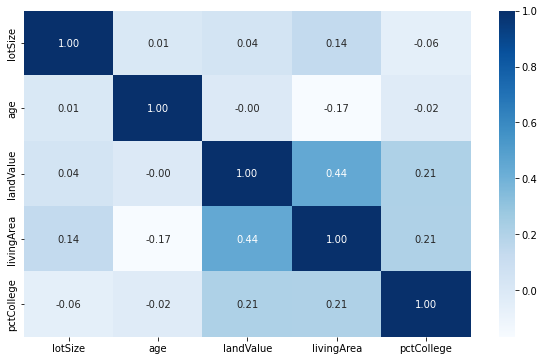

In [ ]:
# Create correlation heatmap for continuous variables
features = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
fig, ax = plt.subplots(figsize=(10,6))
corr = X_train_simplified[features].corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, cmap="Blues", annot=True, fmt=".2f");

Most correlations not along the main diagonal are low, but we see that there is a sizable correlation between land value and living area. While not a terribly high correlation at 0.44, this is not ideal from a linear regression standpoint and indicates multicollinearity is present.

L1 regularization often suffers with predictions when the data exhibits mutlicollinearity as the optimization algorithm doesn't work as well. Luckily, there is another type of regularization, **L2 regularization**, which is very good at addressing multicollinearity. Let's proceed to apply L2 regularization to the current set of features.

## Applying L2 regularization to address multicollinearity (40 min)

A linear regression model that utilizes L2 regularization is called **Ridge regression**. L2 regularization adds the squared magnitude of the regression model coefficients ($\beta_j$) to the OLS loss function:

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{blue}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

L2 regularization also shrinks the $\beta_j$ coefficients toward zero, however the effects of shrinkage are typically less than LASSO regression. Let's fit the model and examine the new coefficients:

In [ ]:
# Fitting the model
model_l2 = linear_model.Ridge(alpha=46.2, fit_intercept=True) # higher alpha for stronger regularization
results_l2 = model_l2.fit(X_train_simplified, y_train)

Below are the model coefficient names followed by the fit $\beta$ values. The coefficients are sorted from smallest to largest:

In [ ]:
sorted(zip(X_train_simplified.columns, results_l2.coef_), key=lambda x: x[1])

[('newConstruction', -0.0094667921542772),
 ('bedrooms', -0.004526499349889266),
 ('age', -0.003979094915839626),
 ('heating_hot water/steam', -0.0034513129436662044),
 ('pctCollege', -0.0005084987354366422),
 ('sewer_public/commercial', 0.00022959222210271226),
 ('sewer_septic', 0.0006730915673456996),
 ('heating_hot air', 0.002213153001592102),
 ('fireplaces', 0.002859991278411837),
 ('fuel_gas', 0.003224238417195982),
 ('centralAir', 0.003667604779328431),
 ('lotSize', 0.00454338350897421),
 ('rooms', 0.007975874701918021),
 ('waterfront', 0.009482287342842595),
 ('bathrooms', 0.01322554318283664),
 ('landValue', 0.02931110270721167),
 ('livingArea', 0.042448605543419365)]

Here, we see ```livingArea``` and ```landValue``` have the largest coefficients. This was expected given that the original data visualization exploration of this analysis showed a significant relationship between these variables and housing prices.

However, it is important to ask why we chose to use $\lambda = 46.2$ in this fit.  The value of $\lambda$ may significantly affect the model coefficients so it must be chosen with care. The following section explores one method for graphically choosing an optimal $\lambda$ value.

### How to tune the regularization parameter $\lambda$  (35 min)

In order to select an appropriate parameter $\lambda$, we will use the mean-squared-error (MSE) of the model applied to our validation set. Remember that the MSE of the model is calculated by comparing the model predictions to the true values. Here, this means comparing the predicted house prices from the L2 regularized model to the actual house prices. Lower values of mean-squared-error indicate better model performance.

Let's sweep through $\lambda$ values and see the effects on the model performance. We will compare performance on the training and validation sets. Recall that higher $\lambda$ values lead to stronger regularization:

In [ ]:
# Loop through different lambda values
lambdas = np.arange(0.1, 100.0, 0.1)

coefs = []
mse_train = []
mse_vali = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_simplified, y_train)
    mse_train.append(mean_squared_error(y_train, ridge.predict(X_train_simplified))) # train data
    mse_vali.append(mean_squared_error(y_vali, ridge.predict(X_vali_simplified))) # validation data

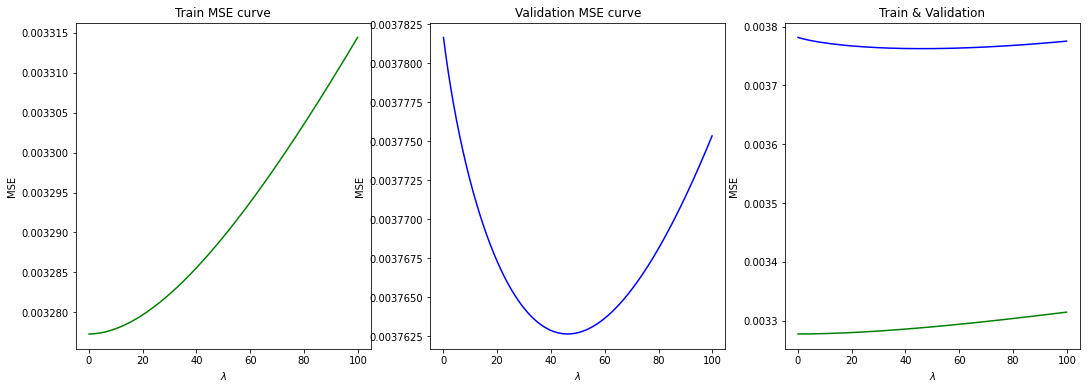

In [ ]:
# Plot results
fig, ax1 = plt.subplots(1,3,figsize=(18,6))

ax1[0].plot(lambdas, mse_train, 'g-')
ax1[0].set_title('Train MSE curve')

ax1[1].plot(lambdas, mse_vali, 'b-')
ax1[1].set_title('Validation MSE curve')

#Place the two plots into one
ax1[2].plot(lambdas, mse_train, 'g-')
ax1[2].plot(lambdas, mse_vali, 'b-')
ax1[2].set_title('Train & Validation')


for ax in ax1.flat:
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('MSE')
    
    
plt.show()

Here, we see the model is slightly overfitting when $\lambda$ is small. The validation set MSE is much higher than the train MSE and the model is mostly unregularized (i.e. the model is linear regression with no extra terms in the optimization function).

The model is slightly underfitting when $\lambda$ is large. The effect of a large $\lambda$ is to increase the regularization strength, effectively make the model restricted in what coefficients it can use to fit the data. With a large $\lambda$ we see the model struggles on both the train and test data (high MSE for both train and test data), indicating that the model is underfitting.

Thus, we need to choose a lambda that balances overfitting and underfitting. From the validation set MSE curve, we see the minimum is achieved between $40$ and $50$. In fact, the code below shows that the minimum is achieved when $\lambda=46.1$. This was the motivation for choosing the $\lambda$ in the previous section. In general, we recommend using such a graphical method to gain an understanding of the effects regularization has on a multiple regression model.

In [ ]:
min_index=mse_vali.index(min(mse_vali))
print("The optimal lambda is: ", lambdas[min_index])
print("Validation MSE=",mse_vali[min_index])
print("Train MSE=", mse_train[min_index])

The optimal lambda is:  46.2
Validation MSE= 0.0037626288497329633
Train MSE= 0.0032879017801583504


### Exercise 4: (15 min):

There are a couple of disadvantages when extracting a *fixed* validation set from the beginning of our analysis: (i) if our data set is small, the size of our training set reduces and our models will have less predictive power, and (ii) the choice of the regularization parameter will end up being highly dependent on the validation set. Thus, it is often recommended to use a method such as $k$-fold cross-validation to estimate the best parameter $\lambda$.  

Estimate the best $\lambda$ using the following procedure:

1. Split the `X_rest_simplified` data set into $k=10$ folds using the `sklearn.model_selection` function `KFold`.

2. For each fold $f$, normalize the data set as before. Then, for each $\lambda$ in `lambdas = np.arange(0.1, 100.0, 0.1)`, fit a Ridge regression and compute the MSE of the fold's test data. Call this value $\text{MSE}_{f,\lambda}$.

3. For each $\lambda$, compute the mean MSE across all folds; that is $\text{MSE}_\lambda:=\frac{1}{10}\sum_{f=1}^{10} \text{MSE}_{f,\lambda}$.

4. Draw a plot of $\lambda$ versus $\text{MSE}_\lambda$ and conclude. 

**Hint:** You can extract the data of each fold using a loop like this one:
```
kf=KFold(n_splits=10,random_state=0)

for index_train, index_test in kf.split(X_rest_simplified):
    
    #Extract the data of the fold
    X_train_fold, y_train_fold=X_rest_simplified.iloc[index_train], y_rest[index_train]
    X_test_fold, y_test_fold=X_rest_simplified.iloc[index_test], y_rest[index_test]
    ... (Rest of your code)
    
```

**Answer.** A sample solution is shown below:

In [ ]:
kf=KFold(n_splits=10)

MSE_total=[]
for index_train, index_test in kf.split(X_rest_simplified):
    
    #Extract the data of the fold
    X_train_fold, y_train_fold=X_rest_simplified.iloc[index_train], y_rest[index_train]
    X_test_fold, y_test_fold=X_rest_simplified.iloc[index_test], y_rest[index_test]
    
    #Normalize the data:
    training_fold_mean = X_train_fold.mean()
    training_fold_std =  X_train_fold.std()
    X_train_fold = (X_train_fold - training_fold_mean) / training_fold_std # normalize (use training mean and training std)
    X_test_fold = (X_test_fold - training_fold_mean) / training_fold_std # normalize (use training mean and training std)
   
    MSE_fold=[]

    for l in lambdas:
        ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
        ridge.fit(X_train_fold, y_train_fold)
        
        #Compute the MSE for the test data
        MSE_fold.append(mean_squared_error(y_test_fold, ridge.predict(X_test_fold)))
    
    MSE_total.append(MSE_fold)

Text(0.5, 1.0, 'Mean MSE curve')

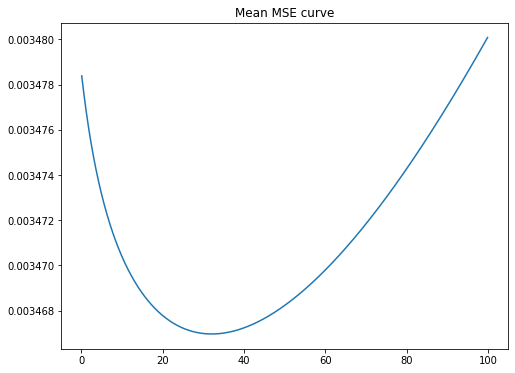

In [ ]:
#Next, we compute the mean for each lambda:

MSE_lambdas=np.matrix(MSE_total).mean(0).reshape(999,1)
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(lambdas, MSE_lambdas)
ax.set_title('Mean MSE curve')


In [ ]:
min_index=np.argmin(MSE_lambdas)
print("The optimal lambda is: ", lambdas[min_index])
print("Average MSE is:", min(MSE_lambdas))

The optimal lambda is:  32.1
Average MSE is: [[0.00346697]]


### Exercise 5: (4 min)

In L2 regularization, as $\lambda$ gets closer to zero, how would the house price model predictions behave? Compare to the case where we fit a multiple linear regression model with no regularization.

A. The house price predictions would become increasingly biased

B. The house price predictions would become less resistant to multicollinearity present in the features

C. The house price predictions do not change as $\lambda$ changes

D. The model would become less complex, leading to lower variance in predictions

**Answer.** (B). The explanation is given below.

Explanation:
Answer (A) is incorrect since as $\lambda$ becomes closer to zero, this is effectively reducing the strength of the regularization (thus removing model bias).

Answer (B) is correct as reducing the $\lambda$ reduces the strength of the regularization. L2 regularization is primarily used to reduce the effects of multicollinearity by controlling the model complexity. Higher values of $\lambda$ lead to a more regularized model, thus lesser values of $\lambda$ will become less resistant to multicollinearity.

Answer (C)  is incorrect since the predictions will change as $\lambda$ changes since the regularization is part of the model's objective function. The objective function is minimized during model fitting, and because $\lambda$ is part of the optimization procedure, changing its value will also change the resulting model, and thus change the model estimates.

Regarding answer (D), decreasing $\lambda$ leads to a more complex model. Through increasing $\lambda$ the model becomes less complex, thus helping aid against overfitting.

### Exercise 6: (10 min)

We've fit a L2 regularized multiple linear regression to predict housing data and looked at how the chosen $\lambda$ affects the train and test error. We'd like to see how the coefficients are affected by the choice of $\lambda$ as well. Write a script to change the value of $\lambda$ and look at how the fit Ridge regression coefficients change. Namely, write a script to produce the following plot. Each line of the plot corresponds to a single feature's coefficient as the value of $\lambda$ changes.

In [ ]:
Image("ridge_coef_plot.png", width=500)

**Answer.** One possible solution is shown below:

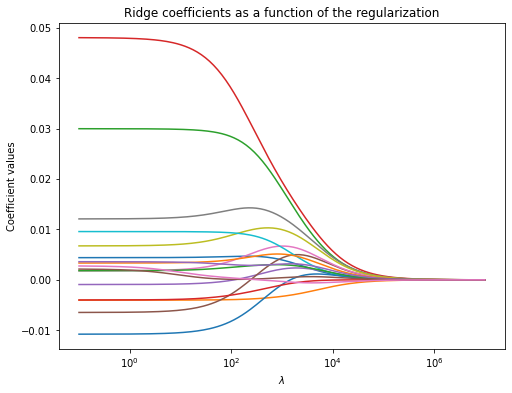

In [ ]:
# Loop through multiple values of lambda and record fit coefficients
lambdas = np.logspace(-1, 7, 200)

coefs = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_simplified, y_train)
    coefs.append(ridge.coef_)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel('$\lambda$')
plt.ylabel("Coefficient values")
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()
#plt.savefig('ridge_coef_plot.png', bbox_inches='tight')

Each line above corresponds to one coefficient's path as $\lambda$ increases from left to right. We see that as the regularization strength increases, all the coefficients eventually become zero. This is the shrinking effect of regularization, where a very large $\lambda$ will force all model coefficients to zero  (due to the optimization prodedure minimizing the objective function). Having all the coefficients go to zero will lead to underfitting as the model predictions become too restricted.

In terms of decreasing $\lambda$ to very small values, it's clear the model coefficients eventually reach a constant value for small values of $\lambda$. This illustrates that as $\lambda$ becomes small, the regularization essentially disappears and the coefficients will be the same as if no regularization was applied at all. Depending on the data, this could lead to overfitting.

Thus, there is a trade-off between overfitting and underfitting when choosing an optimal $\lambda$ value. Too high a $\lambda$ may underfit, while too low a $\lambda$ may overfit. By choosing the appropriate $\lambda$ through careful observation and analysis, regularization techniques can be a powerful tool to prevent and control overfitting.

## Elastic Net regularization (35 min)

Now that we've applied L1 and L2 regularization individually, is there a method by which we can gain their benefits together? Fortunately, the sparsity benefits of L1 and robustness and prevention against overfitting benefits of L2 can be shared in a method named **Elastic Net regression**.

L1 regularization adds the absolute values of the betas to the objective function:

$$Loss(Data\ |\ Model) + \color{blue}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

On the other hand, L2 regularization adds the squared magnitudes of the betas to the objective function:

$$Loss(Data\ |\ Model) + \color{blue}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

Elastic net can be a powerful method to encourage both a sparse solution and a solution that is robust against detrimental characteristics like multicollinearity. Given the data $(y_1, ..., y_n)$ and the observed features for each $y_i$, namely $(x_{i1}, ... ,x_{ip})$, a regression model with $p$ parameters $(\beta_0, ..., \beta_p)$ takes the form,

$$y_i = \sum_{j=1}^{p} x_{ij}\beta_j .$$

Elastic net regularization blends both L1 and L2 regularization penalties to include both the absolute value and squared magnitude of the beta coefficients in the loss function:

$$\sum_{i=1}^{n} (y_i - \sum_{j=1}^{p} x_{ij} \beta_j)^2 + \color{blue}{\alpha \rho \sum_{j=1}^{p}\big| \beta_j \big|} + \color{blue}{\alpha(1-\rho) \sum_{j=1}^{p}\beta_j^2}.$$

Here, $\alpha$ is the regularization rate, and $\rho$ controls the balance between L1 and L2 regularization in the loss function. Namely, $\rho = 1$ results in a pure L1 penalty, $\rho = 0$ results in a pure L2 penalty, while $0 < \rho < 1$ results in a blended elastic net regularization.

Similar to how we calibrated $\lambda$ in our discussion of L2 regularization, it is helpful to construct graphs as a function of the elastic net regularization rate $\alpha$. Let's sweep through a list of different $\alpha$ values and plot the coefficients as a function of $\alpha$:

In [ ]:
# Loop through different regularization alpha values and record fit coefficients at each value
alpha_list = np.logspace(-5, 1, 50)

coefs = []
for a in alpha_list:
    enet = linear_model.ElasticNet(random_state=0, alpha=a, l1_ratio=0.5, fit_intercept=True)
    enet.fit(X_train_simplified, y_train)
    coefs.append(enet.coef_.ravel())

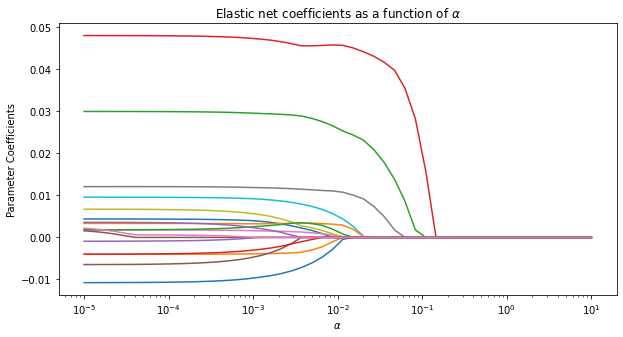

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alpha_list, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel(r'$\alpha$')
plt.ylabel('Parameter Coefficients')
plt.title(r'Elastic net coefficients as a function of $\alpha$')
plt.axis('tight');

From the above plot, we see that as $\alpha$ increases beyond ~0.1, all the coefficients become zero. This indicates the regularization at such an alpha is too strong. On the other hand, very small $\alpha$ values lead to a weak regularization.  We can see as the $\alpha$ values decrease from right to left, the parameter estimates start to be more significantly affected near $10^{-4}$. This incidates at that point the regularization starts to have an effect on the model fit.

Now that we have an idea of how the coefficients are affected by $\alpha$, let's take a look at how to choose the optimal $\alpha$ value.

### A method to choose the optimal  $\alpha$ (10 min)

Choosing an optimal $\alpha$ is important. Choosing an $\alpha$ that is too large will cause the coefficients of the model to become too constrained and reduce out-of-sample model accuracy. On the other hand, choosing an $\alpha$ that is too small can result in the regularization having little effect, thus reducing the primary purpose of regularization as a control against overfitting.

One method to select an optimal $\alpha$ is to observe the R-squared of the model as a function of $\alpha$, and subsequently select the $\alpha$ that gives the highest test set R-squared value. Let's fit the elastic net regularized linear regression model for different values of $\alpha$ and see the effects on the R-squared for both training and validation sets (we could also use cross-validation here). Note that we will set the ratio of L1 and L2 regularization (denoted as the `l1_ratio` parameter in `linear_model.ElasticNet()`, and often denoted mathematically as $\rho$) to 0.5 in this analysis, with the idea of balancing L1 and L2 regularization effects:

In [ ]:
# Compare progression of train and test errors and alpha varies
alphas = np.logspace(-5, 1, 50)
enet = linear_model.ElasticNet(random_state=0, l1_ratio=0.5, fit_intercept=True)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train_simplified, y_train)
    train_errors.append(enet.score(X_train_simplified, y_train))
    test_errors.append(enet.score(X_vali_simplified, y_vali))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal alpha regularization parameter : %.6f" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

Optimal alpha regularization parameter : 0.000687


Let's see how the R-squared of the training and test data evolves as the $\alpha$ parameter is changed:

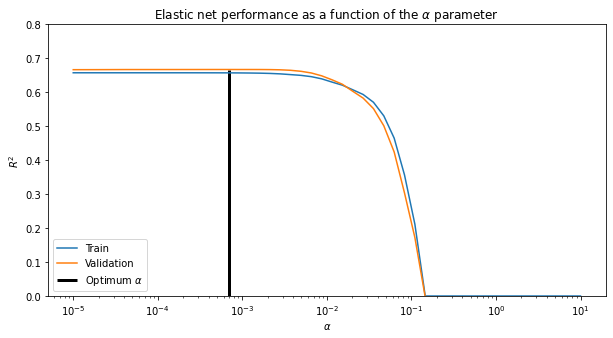

In [ ]:
# Plot R-squared as a function of alpha
fig,ax = plt.subplots(figsize=(10,5))
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Validation')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',linewidth=3, label=r'Optimum $\alpha$')
plt.legend(loc='lower left')
plt.ylim([0, 0.8])
plt.title(r'Elastic net performance as a function of the $\alpha$ parameter')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R^2$');

We see that the optimal value of $\alpha$ is approximately 0.0006.

### Exercise 7: (5 min)

When choosing optimal parameters $\alpha$ and $\lambda$, we split the data into two sets, train and validation.  The train set is used to fit the elastic net regularized linear regression model, while the validation set is used to calculate the R-squared for each different value of $\alpha$. What is the primary reason for splitting into train and validation sets when choosing an optimal $\alpha$ for this elastic net regression task? </font>

(A) By choosing $\alpha$ using in-sample data, we reduce the risk of overfitting

(B) The model complexity is decreased which leads to a lower chance of overfitting

(C) To aid in out-of-sample model prediction accuracy, $\alpha$ is selected using the validation set not involved in the fitting process

(D) Since $\alpha$ is a single variable, splitting into train and validation sets reduces calculation time aiding in model development

**Answer.** (C). The explanation is given below.

Answer (A) is incorrect as we choose $\alpha$ using out-of-sample test data, not the in-sample train data that was used to fit the linear model.

Answer (B) is incorrect as the model complexity is not decreased by splitting into train and validation sets. The model complexity remains unchanged, since the data the model is fit on or tested on is not involved in determining the complexity of the model.

Splitting into train and validation sets allows us to fit using the in-sample data, and then test on out-of-sample data to ensure the model does not overfit. Thus by selecting $\alpha$ using the testing data that is not involved in the modelling fitting (hence out-of-sample test data), this aides in having better out-of-sample prediction accuracy. Thus, answer (C) is the correct answer.

Though splitting into train and test data can indeed reduce training times in model development, this is not a reason why we split into training and testing data for choosing and optimal $\alpha$. Thus, answer (D) is incorrect.

### Exercise 8: (15 min)

Write a script to change $\rho$ and see how the optimal $\alpha$ changes (based on maximum test set R-squared as seen above). Namely, what are the optimal values of $\alpha$ using for the following values of $\rho$: [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]? Comment on what happens when $\rho$ is 0 and when $\rho$ is 1.

**Answer.** One possible solution is shown below:

In [ ]:
# Compare progression of train and test errors and alpha and rho vary
alphas = np.logspace(-5, 1, 50)
rhos = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
list_alpha_optim = []
for rho in rhos:
    train_errors = []
    test_errors = []
    enet = linear_model.ElasticNet(random_state=0, l1_ratio=0.5, fit_intercept=True)
    for alpha in alphas:
        enet.set_params(alpha=alpha, l1_ratio=rho)
        enet.fit(X_train_simplified, y_train)
        train_errors.append(enet.score(X_train_simplified, y_train))
        test_errors.append(enet.score(X_vali_simplified, y_vali))

    i_alpha_optim = np.argmax(test_errors)
    alpha_optim = alphas[i_alpha_optim]
    print("Optimal alpha for rho = %.6f: %.6f" % (rho, alpha_optim))
    list_alpha_optim.append(alpha_optim)

Optimal alpha for rho = 0.100000: 0.006551
Optimal alpha for rho = 0.200000: 0.002812
Optimal alpha for rho = 0.300000: 0.002121
Optimal alpha for rho = 0.400000: 0.000910
Optimal alpha for rho = 0.500000: 0.000687
Optimal alpha for rho = 0.600000: 0.000518
Optimal alpha for rho = 0.700000: 0.000391
Optimal alpha for rho = 0.800000: 0.000391
Optimal alpha for rho = 0.900000: 0.000391


We find that the optimal alpha decreases as $\rho$ increases.

## Insights from the final elastic net model (10 min)

For predicting home prices with a balanced portion of L1 and L2 regularization, we found an optimal $\alpha = 0.000687$ to use for the elastic net model. Let's take a look at our final model results and see if there are any insights we can draw:

In [ ]:
# Looking at the coefficents of the final model
final_elastic_net_model = linear_model.ElasticNet(random_state=0, alpha=0.000687, l1_ratio=0.5, fit_intercept=True)
final_elastic_net_model.fit(X_train_simplified, y_train)
sorted(zip(X_train_simplified.columns, final_elastic_net_model.coef_), key=lambda x: x[1])

[('newConstruction', -0.01002543782413462),
 ('bedrooms', -0.005268803885894721),
 ('age', -0.0039433234263037895),
 ('heating_hot water/steam', -0.0033244612994566057),
 ('pctCollege', -0.00035093921586091463),
 ('sewer_public/commercial', -0.0),
 ('sewer_septic', 0.00018835581168731892),
 ('fireplaces', 0.0016493839694881535),
 ('heating_hot air', 0.0023218363876099345),
 ('fuel_gas', 0.002713013352425113),
 ('centralAir', 0.0032605967324633553),
 ('lotSize', 0.00411525781160422),
 ('rooms', 0.005989114075979555),
 ('waterfront', 0.009320611007026608),
 ('bathrooms', 0.011943697845352536),
 ('landValue', 0.02968736810689849),
 ('livingArea', 0.047571863302924594)]

Since we chose to perform standardization of the data before fitting (to make the features on the same scale so as to not adversely influence the fit coefficents) we must take care in interpreting the output of the model.

The results of this elastic net model have pushed some of the coefficients toward zero, while fully reducing some of the less significant features to have zero coefficients (**sewer_public/commercial**).

We see that the housing prices are greatly positively influenced by **livingArea** and **landValue**. This follows our intuition as both of these quantities should naturally lead to a higher desired house price.

Moreover, the **newConstruction**, **bedrooms**, and **age** variables have large negative betas. While age follows what we expect (older homes can have outdated features and thus can decline in price) the newConstruction and bedrooms features may warrant further analysis as to why the variable leads to a negative coefficient. There may be some hidden variables at play that we lack data for; for example the new construction may be sourced by an untrusted contractor company which could lead to lower home prices.

### Exercise 9: (5 min)

Use the test data to evaluate the performance of the models `res_linear` (OLS with no regularization), `model_l2` (Ridge regression with $\lambda=46.2$) and `final_elastic_net_model` (Elastic net with $\alpha=0.000687$ and $\rho=0.5$).

**Answer.** One possible solution is shown below:

In [ ]:
#We compute the performance using the MSE: 
print("OLS MSE:", mean_squared_error(y_test, res_linear.predict(sm.add_constant(X_test_simplified))))
print("Ridge MSE:", mean_squared_error(y_test, model_l2.predict(X_test_simplified)))
print("Elastic Net MSE:", mean_squared_error(y_test, final_elastic_net_model.predict(X_test_simplified)))

OLS MSE: 0.0033886964841969482
Ridge MSE: 0.00340064621794767
Elastic Net MSE: 0.0034006529664043854


The unregularized model `res_linear` seems to perform better than its regularized counterparts on the test data. This may be an indicative that the model was not overfitting our training data after all. Remember that regularization is a tool which attempts to make our models more robust on out-of-sample data, and it often leads to better results than its unregularized counter parts (especially when the number of parameters is large). After all, we used regularization to build the model `res_linear`, which performed much better than our initial model. However, this does not mean that regularized models should perform better in every scenario.

## Conclusions (5 min)

In this case, we set out to determine salient variables that could help explain home prices. Through multiple linear regression, L1, L2, and elastic net regularization modeling we have found a number of useful and unhelpful variables for the analysis.

A number of variables that proved unhelpful include **fuel_oil** and **heating_electric**. Indeed, many of the categorical variables did not have significant $p$ values so future analysis could investigate why this was the case.

Salient variables from the regression analysis included **landValue** and **livingArea**. Both of these variables showed a strong relationship to price in the original exploratory data analysis section, each had significant $p$ values in the multiple linear regression section, and both were utilized through the L1, L2, and elastic net regularization sections.

## Takeaways (5 min)

In this case, we have: 

1. Applied the foundations of model regularization for linear regression. 
2. Learned about L1 regularization and how LASSO can help to rule out inessential parameters. Although this technique is quite powerful, it is wise to not remove parameters without a proper justification.
3. Learned about L2 regularization and how it can be used to deal with colinearity among our predictors.
4. Learned a powerful tool that helps us guess the correct values of the *hyperparameters* of our models. Namely, we learned how to use validation sets and $k$-fold cross validation to create visualizations that help us with the tuning of these parameters.
5. Finally, we learned elastic net regularization. This is a mix of L1 and L2 regularizations, which allows us to have flexibility in the type of regularization we are more concerned about.

Building on this knowledge, you can utilize regularization techniques to aid your models against overfitting and improve prediction accuracy. Robust predictions are incredibly important not only for improved model estimates but also to help one maintain confidence in model predictions out-of-sample and in production settings. Quantitatively-driven business decisions depend on quality estimates, and regularization techniques are a useful tool to achieve that goal.